In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import time

Number of units:  1654
State Info
Adjacency
Neighborhoods

Given district map:  Congress-CMPTTV1_TractAssignment.csv

Number of counties spanned by districts:  122
Number of whole counties:  110
Number of border nodes:  285
Max population deviation:  0.004069432013092733
Total perimeter:  4725.244454000001


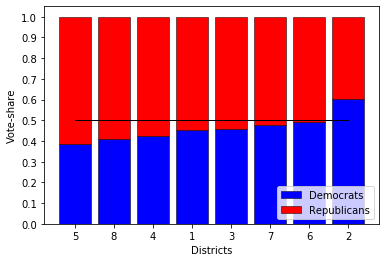

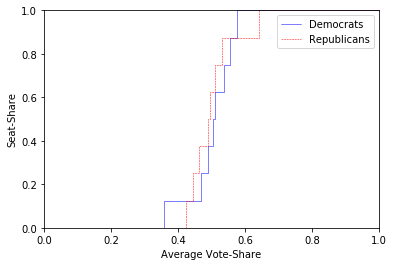

PA:  0.032891669948002376
MM (+: Dem advantage, -: Rep advantage):  -0.007640230337770282
EG values for shifts (+: Rep advantage, -: Dem advantage):
0.2038167277842326
0.22381672778423264
0.2438167277842326
0.26381672778423254
0.2838167277842325
0.3038167277842326
0.2010382082241773
0.22103820822417736
0.09184721305803238
0.11184721305803237
-0.11186661498184516
Nominal EG:  0.3038167277842326
Absolute Max EG Shift:  0.3038167277842326
Initial avg margin (Cmpttv):  0.12612648092484824
Initial max margin:  0.22560820351703437
<= 10%:
#:  4
	# Dem:  0
	# Rep:  4
<= 5%:
#:  1
	# Dem:  0
	# Rep:  1
0.45221298858069914
0.6049219214593473
0.45884103054858577
0.4257855457972947
0.3871958982414828
0.49325256607543183
0.4748780092837213
0.4082499592327387
# Dem Seats:  1
# Rep Seats:  7
Percent Dem:  46.5 %
Percent Rep:  53.5 %

# plurality-Black MM districts:  1
# plurality-Lat/Hisp MM districts:  0
# plurality-NH-white MM districts:  0

District percentages:
District  1 : % NH-white =  80.75 

In [4]:
# FUNCTIONS ---------------------------------------------------------------------------------------

# Reads in data from a given .csv file
def readData(file):
    inFile = open(file,'r')
    reader = csv.reader(inFile,delimiter = ',')

    polished = [line for line in reader if (line != [] and line != ['',''])]
            
    inFile.close()
    
    del(polished[0])
    
    polished.sort()
    
    return polished


# Updates partisan asymmetry objective function
def update_PA(FD):
    FD_copy = FD.copy()
    curve_Dem = []
    all_won = False
    all_lost = False
    
    # Increase average vote-share until dems win all seats, recording breakpoints for seat gains
    while not all_won:
        change_increase = [(0.5 - fd) for fd in FD_copy if fd < 0.5]
        if len(change_increase) == 0:
            all_won = True
            voteShare_Dem = (sum(FD_copy))/(len(FD_copy))
            seatShare_Dem = (len(FD_copy) - len(change_increase))/(len(FD_copy))
            curve_Dem.append([voteShare_Dem,seatShare_Dem])
            continue
            
        delta_increase = min(change_increase)
        
        voteShare_Dem = (sum(FD_copy))/(len(FD_copy))
        seatShare_Dem = (len(FD_copy) - len(change_increase))/(len(FD_copy))
        curve_Dem.append([voteShare_Dem,seatShare_Dem])
        
        FD_copy = [(fd + delta_increase) for fd in FD_copy] # Increase district vote-shares by enough for dems to win one more seat
        
    current = curve_Dem[0]
    del(curve_Dem[0])
    FD_copy = FD.copy()
    
    # Indicator to not record point in first loop iteration, since it's not a breakpoint
    goAhead = False
    
    # Decrease average vote-share until dems lose all seats, recording breakpoints for seat losses
    while not all_lost:
        change_decrease = [(fd - 0.5) for fd in FD_copy if fd > 0.5]
        if len(change_decrease) == 0:
            all_lost = True
            voteShare_Dem = (sum(FD_copy))/(len(FD_copy))
            seatShare_Dem = (len(change_decrease)+1)/(len(FD_copy))
            curve_Dem.append([voteShare_Dem,seatShare_Dem])
            continue
            
        delta_decrease = min(change_decrease)
        
        voteShare_Dem = (sum(FD_copy))/(len(FD_copy))
        seatShare_Dem = (len(change_decrease)+1)/(len(FD_copy))
        if goAhead:
            curve_Dem.append([voteShare_Dem,seatShare_Dem])
            
        goAhead = True
        
        FD_copy = [(fd - delta_decrease) for fd in FD_copy]
    
    
    curve_Dem.sort()
    
    # Create rep curve from dem curve
    curve_Rep = [[1-cd[0],1-cd[1]+(1/len(FD_copy))] for cd in curve_Dem]
    curve_Rep.sort()
    
    # Calculate area between curves
    integ = 0
    for i in range(0,len(curve_Dem)):
        dem = curve_Dem[i]
        rep = curve_Rep[i]
        rect = (1.0/(len(FD_copy)))*(abs(dem[0]-rep[0]))
        integ += rect
        
        
    # Plot dem and rep curves
    x = [cd[0] for cd in curve_Dem]
    y = [cd[1]-1.0/(len(FD_copy)) for cd in curve_Dem]
    x.append(1.0)
    y.append(1.0)
    #plt.step(x,y,'b',linewidth=.5,label='Party A')
    plt.step(x,y,'b',linewidth=.5,label='Democrats')
    
    x = [cd[0] for cd in curve_Rep]
    y = [cd[1]-1.0/(len(FD_copy)) for cd in curve_Rep]
    x.append(1.0)
    y.append(1.0)
    #plt.step(x,y,'r--',linewidth=.5,label='Party B')
    plt.step(x,y,'r--',linewidth=.5,label='Republicans')
    
    plt.axis([0,1,0,1])
    plt.legend()
    plt.xlabel('Average Vote-Share')
    plt.ylabel('Seat-Share')
    plt.savefig('PA_'+plan[:-4]+'.pdf',dpi=500)
    plt.show()
    
    return (integ)


# Updates shifted efficiency gap objective function
def update_ShiftedEG(FD,TV):
    
    # Shifted Efficiency Gap objective function (MO)
    percentShiftsNeg = [-0.05,-0.04,-0.03,-0.02,-0.01,0.0]
    percentShiftsPos = [0.01,0.02,0.03,0.04,0.05]
    allVotes = sum(TV)
    EG_shift = []

    for s in percentShiftsNeg:
        fracDem_shift = [max(fd+s,0.0) for fd in FD]
        numDem_shift = []
        numRep_shift = []
        for i in range(0,len(TV)):
            numDem_shift.append(fracDem_shift[i]*TV[i])
            numRep_shift.append((1-fracDem_shift[i])*TV[i])
        
        wasted_shift = []
        for i in range(0,len(numDem_shift)):
            if numDem_shift[i] >= numRep_shift[i]:
                wasted_shift.append(.5*(numDem_shift[i]-3*numRep_shift[i]))
            else:
                wasted_shift.append(.5*(3*numDem_shift[i]-numRep_shift[i]))
                
        #EG_shift.append(abs(sum(wasted_shift))/allVotes)
        EG_shift.append(sum(wasted_shift)/allVotes) # Positive => Rep. advantage, negative => Dem. advantage

        
    for s in percentShiftsPos:
        fracDem_shift = [min(fd+s,1.0) for fd in FD]
        numDem_shift = []
        numRep_shift = []
        for i in range(0,len(TV)):
            numDem_shift.append(fracDem_shift[i]*TV[i])
            numRep_shift.append((1-fracDem_shift[i])*TV[i])
            
        wasted_shift = []
        for i in range(0,len(numDem_shift)):
            if numDem_shift[i] >= numRep_shift[i]:
                wasted_shift.append(.5*(numDem_shift[i]-3*numRep_shift[i]))
            else:
                wasted_shift.append(.5*(3*numDem_shift[i]-numRep_shift[i]))
                
        #EG_shift.append(abs(sum(wasted_shift))/allVotes)
        EG_shift.append(sum(wasted_shift)/allVotes) # Positive => Rep. advantage, negative => Dem. advantage

        
#     print('Shifted EG:')
#     for val in EG_shift:
#         print(val)
        
#     print('Nominal EG: ',EG_shift[5])
        

    #return max(EG_shift)
    return EG_shift # Return entire list


# READ IN ALL STATE DATA --------------------------------------------------------------------------------

# District plan files
BigFolder = 'FinalPlans_AssignmentFiles/Congress_TractAssignment'

maps = [p for p in os.listdir(BigFolder+'/') if not p.startswith('.')]
maps.sort()

# Specify select maps from BigFolder (comment out to evaluate entire folder)
maps = ['Congress-CMPTTV1_TractAssignment.csv']


# State files
StateFolder = 'MO_TractInput'

files = [t for t in os.listdir(StateFolder+'/') if not t.startswith('.')]
files.sort()


# STATE INFO -----------------------------------------------------------------------------------------------

# Read in state info
adj = readData(StateFolder+'/'+files[0])
unitInfo = readData(StateFolder+'/'+files[1])

# Gather dictionaries of unit info
ids = [] # GEOIDs
pop = {} # total population
votes = {} # dem/rep votes
popW = {} # white population
popB = {} # Black/African American population
popL = {} # Lat/Hisp population

for u in unitInfo:
    ids.append(u[0])
    pop[u[0]] = int(u[1])
    votes[u[0]] = [float(u[2]),float(u[3])]
    popW[u[0]] = int(u[4])
    popB[u[0]] = int(u[5])
    popL[u[0]] = int(u[6])


print('Number of units: ',len(ids))

# Insert dummy node 0
ids.insert(0,'0')
pop['0'] = 0
votes['0'] = [0.0,0.0]
popW['0'] = 0
popB['0'] = 0
popL['0'] = 0
    
print('State Info')
numUnits = len(ids)

# ADJACENCY ------------------------------------------------------------------------------------------------

# Make cleaned adjacency dictionary
edgesLength = {}

# Populate adjacency matrix with length of shared segment for normal adjacency

# Normal adjacency
for e in adj:
    if e[2] != '0' and e[2] != '0.0' and e[0] != 'other' and e[1] != 'other':
        edgesLength[(e[0],e[1])] = float(e[2])

            
print('Adjacency')


# NEIGHBORHOODS -----------------------------------------------------------------------------------

# Gather a list of normal neighbors for every unit
neighborhoods = {}

for i in ids:
    neighborhoods[i] = []

for pair in edgesLength:
    neighborhoods[pair[0]].append(pair[1])
    neighborhoods[pair[1]].append(pair[0])

           
print('Neighborhoods')


# ITERATE THROUGH EACH DISTRICT PLAN --------------------------------------------------------------

for plan in maps:
    
    # Record evaluation time for each map
    start = time.time()
    
    # Open file for metric values
    outFile = open('Evaluation_'+plan[:-4]+'.txt','w')

    # Record map name
    outFile.write('Given district map: '+str(plan))
    print('\nGiven district map: ',plan)
    
    
    
# DISTRICTS ---------------------------------------------------------------------------------------
 
    # Read in plan data, clean data
    data_raw = readData(BigFolder+'/'+plan)
    data = {}
    numDistricts = 0
    for d in data_raw:
        data[d[0]] = int(d[1])
        if int(d[1]) > numDistricts:
            numDistricts = int(d[1])

    # Insert dummy node 0 in dummy district 0 (to represent outside the district)
    data['0'] = 0
    numDistricts += 1

    # Group units by part
    partition = [[] for p in range(0,numDistricts)]

    #for i in ids:
    for i in data:
        partition[data[i]].append(i)

    # Count number of counties spanned by each district
    numCounties = []
    for p in partition[1:]:
        temp = []
        for i in p:
            temp.append(i[0:5])

        temp = list(set(temp))
        numCounties.append(len(temp))
            
    # Record number of counties spanned
    outFile.write('\n\nNumber of counties spanned by districts: ' + str(sum(numCounties)))
    print('\nNumber of counties spanned by districts: ',sum(numCounties))
    
    
    # Calculate number of districts with area in each county
    counties = {}
    #for i in ids:
    for i in data:
        if i != '0':
            counties[i[0:5]] = []

    #for i in ids:
    for i in data:
        if i != '0':
            counties[i[0:5]].append(data[i])
        
    countWhole = 0
    for c in counties:
        if len(list(set(counties[c]))) == 1:
            countWhole += 1

    # Record number of whole counties
    outFile.write('\nNumber of whole counties: ' + str(countWhole))
    print('Number of whole counties: ',countWhole)
    

                
# BORDER NODES ------------------------------------------------------------------------------------

    # Gather units on the border of each district
    borderNodes = {}
    for i in range(1,numDistricts):
        borderNodes[i] = []

    numBN = 0
    #for node in ids:
    for node in data:
        dist = data[node]
        for nb in neighborhoods[node]:
            otherDist = data[nb]
            if otherDist != dist and otherDist != 0 and dist != 0: # Don't want nodes to move to dummy district 0, DON'T need to count units multiple times
                borderNodes[dist].append(node)
                numBN += 1
                break # Exit neighborhood loop if node is already identified as on the border
                
                
    # Record number of border nodes
    outFile.write('\nNumber of border nodes: ' + str(numBN))
    print('Number of border nodes: ',numBN)


# POPULATION --------------------------------------------------------------------------------------

    # Calculate population of each district
    distPop = [0 for i in range(0,numDistricts)]

    #for i in ids:
    for i in data:
        distPop[data[i]] += pop[i]

    meanDistPop = sum(distPop)/(numDistricts-1) #numDistricts-1 bc don't want to include dummy district
    distPop[0] = meanDistPop # Change dummy districts population to the expected

    # Calculate each district's percent difference from expected population
    distPopPercent = [abs(1-(dp)/(meanDistPop)) for dp in distPop]

    popInitial = max(distPopPercent)
    
    # Record max pop dev
    outFile.write('\nMax population deviation: ' + str(popInitial))
    print('Max population deviation: ',popInitial)

    
# COMPACTNESS -------------------------------------------------------------------------------------

    # Calculate district perimeters
    distPerimeter = [0.0 for i in range(0,numDistricts)]
    distPerimeter[0] = 0.0 # Dummy district perimeter

    for i in range(1,numDistricts):
        for b in borderNodes[i]:
            for n in neighborhoods[b]:
                if data[n] != data[b]:
                    if (n,b) in edgesLength:
                        distPerimeter[i] += edgesLength[(n,b)]
                    elif (b,n) in edgesLength:
                        distPerimeter[i] += edgesLength[(b,n)]


    perimInitial = sum(distPerimeter)
    
    # Record compactness
    outFile.write('\nTotal perimeter: ' + str(perimInitial))
    print('Total perimeter: ',perimInitial)
    
    
# VOTES --------------------------------------------------------------------------------------------

    # Calculate fraction of dem, and number of dem/rep in every district
    fracDem = [0.0 for i in range(0,numDistricts)]
    numDem = [0.0 for i in range(0,numDistricts)]
    numRep = [0.0 for i in range(0,numDistricts)]

    for d in data:
        numDem[data[d]] += votes[d][0]
        numRep[data[d]] += votes[d][1]

    for i in range(1,numDistricts):
        fracDem[i] = numDem[i]/(numDem[i]+numRep[i])

    totalVotesByDistrict = [numDem[i]+numRep[i] for i in range(0,len(numDem))]
    totalVotes = sum(totalVotesByDistrict)

    
# EVALUATION ---------------------------------------------------------------------------------------

    # Plot vote-share margins
    test = [fd for fd in fracDem[1:]]
    
    #test = [0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.47, 0.60, 0.68, 0.72]
    
    test.sort()
    fracRep = [1-d for d in test]
    
    forLabels = [[fracDem[i],i] for i in range(1,len(fracDem[1:])+1)]
    forLabels.sort()
    labels = [FL[1] for FL in forLabels]
    labels_str = [str(lab) for lab in labels]
    #print(labels_str)
    
    #x = np.arange(numDistricts-1)
    
    x = np.arange(len(test))
    
    x = [n+1 for n in x]
    y = [.5 for n in x]

    # For MO House
#     plt.bar(x, test, width=1, color='blue', edgecolor='k',linewidth='.35',label='Democrats')
#     plt.bar(x, fracRep, width=1, bottom=test, color='red', edgecolor='k',linewidth='.35',label='Republicans')
    
    # For not MO House
    plt.bar(x, test, color='blue', edgecolor='k',linewidth='.5',label='Democrats')
    plt.bar(x, fracRep, bottom=test, color='red', edgecolor='k',linewidth='.5',label='Republicans')
    
    #plt.xticks([i for i in range(1,numDistricts)])
    plt.xticks([i for i in range(1,numDistricts)],labels_str)
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.plot(x,y,'k-',linewidth='1')
    plt.legend(loc='lower right')
    plt.xlabel('Districts')
    plt.ylabel('Vote-share')
    plt.savefig('Margins_'+plan[:-4]+'.pdf',dpi=500)
    plt.show()


    # Partisan Asymmetry objective function
    
    PA_Initial = update_PA(fracDem[1:])
    
    #PA_Initial = update_PA(test)
    
    outFile.write('\n\nPA: ' + str(PA_Initial))
    print('PA: ',PA_Initial)
    
    # Mean-Median objective function
    meanFD = sum(fracDem[1:])/(numDistricts-1) # len()-1 bc don't want to include dummy district
    medianFD = np.median(fracDem[1:]) # [1:] bc don't want to include dummy district
    MM_Initial = medianFD - meanFD
    outFile.write('\n\nMM (+: Dem advantage, -: Rep advantage): ' + str(MM_Initial))
    print('MM (+: Dem advantage, -: Rep advantage): ',MM_Initial)
    
    # Efficiency Gap objective function
    EGShift = update_ShiftedEG(fracDem[1:],totalVotesByDistrict[1:])
    outFile.write('\n\nEG values for shifts (+: Rep advantage, -: Dem advantage):')
    print('EG values for shifts (+: Rep advantage, -: Dem advantage):')
    for val in EGShift:
        outFile.write('\n'+str(val))
        print(val)
    outFile.write('\nNominal EG: ' + str(EGShift[5]))
    print('Nominal EG: ',EGShift[5])
    EGShift_abs = [abs(eg) for eg in EGShift]
    outFile.write('\nAbsolute Max EG Shift: ' + str(max(EGShift)))
    print('Absolute Max EG Shift: ',max(EGShift))

    # Competitiveness objective function
    compFrac = [abs(2*fd - 1) for fd in fracDem[1:]]
    compFrac.insert(0,0.0)
    CmpttvInitial = sum(compFrac)/(len(compFrac)-1)
    outFile.write('\n\nAvg margin (Cmpttv): ' + str(CmpttvInitial))
    outFile.write('\nMax margin (Cmpttv): ' + str(max(compFrac)))
    print('Initial avg margin (Cmpttv): ',CmpttvInitial)
    print('Initial max margin: ',max(compFrac))
    print('<= 10%:')
    countCmpttv = 0
    countCmpttvD = 0
    countCmpttvR = 0
    for i in range(1,len(compFrac)):
        if compFrac[i] <= 0.1:
            countCmpttv += 1
            if fracDem[i] >= 0.5:
                countCmpttvD += 1
            else:
                countCmpttvR += 1

    print('#: ',countCmpttv)
    print('\t# Dem: ',countCmpttvD)
    print('\t# Rep: ',countCmpttvR)
    outFile.write('\n# Margins <= 10%: ' + str(countCmpttv))
    outFile.write('\n\t\t# Dem: ' + str(countCmpttvD))
    outFile.write('\n\t\t# Rep: ' + str(countCmpttvR))
    
    print('<= 5%:')
    countCmpttv = 0
    countCmpttvD = 0
    countCmpttvR = 0
    for i in range(1,len(compFrac)):
        if compFrac[i] <= 0.05:
            countCmpttv += 1
            if fracDem[i] >= 0.5:
                countCmpttvD += 1
            else:
                countCmpttvR += 1

    print('#: ',countCmpttv)
    print('\t# Dem: ',countCmpttvD)
    print('\t# Rep: ',countCmpttvR)
    outFile.write('\n# Margins <= 5%: ' + str(countCmpttv))
    outFile.write('\n\t\t# Dem: ' + str(countCmpttvD))
    outFile.write('\n\t\t# Rep: ' + str(countCmpttvR))
    
    
    # Number of seats for each party
    demSeats = 0
    repSeats = 0
    for fd in fracDem[1:]:
        print(fd)
        if fd > 0.5:
            demSeats += 1
        else:
            repSeats += 1
            
    print('# Dem Seats: ',demSeats)
    print('# Rep Seats: ',repSeats)
    outFile.write('\n\n# Dem Seats: ' + str(demSeats))
    outFile.write('\n# Rep Seats: ' + str(repSeats))
    
    totalD = 0
    totalR = 0
    for i in range(1,len(numDem)):
        totalD += numDem[i]
        totalR += numRep[i]
        
    print('Percent Dem: ',100*round(float(totalD)/(totalD+totalR),3),'%')
    print('Percent Rep: ',100*round(float(totalR)/(totalD+totalR),3),'%')
    outFile.write('\n\nPercent Dem: ' + str(100*round(float(totalD)/(totalD+totalR),3)) + '%')
    outFile.write('\nPercent Rep: ' + str(100*round(float(totalR)/(totalD+totalR),3)) + '%')
    
    
    
    # Calculate the fraction of district pop that is non-Hispanic white, Black, Latino/Hispanic
    fracW = [0.0 for i in range(0,numDistricts)]
    fracB = [0.0 for i in range(0,numDistricts)]
    fracL = [0.0 for i in range(0,numDistricts)]

    for d in data:
        fracW[data[d]] += popW[d]
        fracB[data[d]] += popB[d]
        fracL[data[d]] += popL[d]

    for i in range(0,numDistricts):
        fracW[i] = float(fracW[i])/distPop[i]
        fracB[i] = float(fracB[i])/distPop[i]
        fracL[i] = float(fracL[i])/distPop[i]

    numPlurB = 0
    numPlurL = 0
    numPlurW = 0

    for i in range(1,numDistricts):
        if fracW[i] < 0.5:
            if fracB[i] > fracW[i] and fracB[i] > fracL[i]:
                numPlurB += 1
            elif fracL[i] > fracW[i] and fracL[i] > fracB[i]:
                numPlurL += 1
            else:
                numPlurW += 1

                
    print('\n# plurality-Black MM districts: ',numPlurB)
    print('# plurality-Lat/Hisp MM districts: ',numPlurL)
    print('# plurality-NH-white MM districts: ',numPlurW)
    outFile.write('\n\n# plurality-Black MM districts: ' + str(numPlurB))
    outFile.write('\n# plurality-Lat/Hisp MM districts: ' + str(numPlurL))
    outFile.write('\n# plurality-NH-white MM districts: ' + str(numPlurW))
    
    print('\nDistrict percentages:')
    outFile.write('\n\nDistrict percentages:\n')
    for i in range(1,numDistricts):
        if fracW[i] < 0.5:
            print('-----' + 'District ',i,': % NH-white = ',round(100*fracW[i],2),'%, % Black = ',round(100*fracB[i],2),'%, % Lat/Hisp = ',round(100*fracL[i],2),'%' + '-----')
            outFile.write('\n-----' + 'District ' + str(i) + ': % NH-white = ' + str(round(100*fracW[i],2)) + '%, % Black = ' + str(round(100*fracB[i],2)) + '%, % Lat/Hisp = ' + str(round(100*fracL[i],2)) + '%' + '-----')
        else:
            print('District ',i,': % NH-white = ',round(100*fracW[i],2),'%, % Black = ',round(100*fracB[i],2),'%, % Lat/Hisp = ',round(100*fracL[i],2),'%')
            outFile.write('\nDistrict ' + str(i) + ': % NH-white = ' + str(round(100*fracW[i],2)) + '%, % Black = ' + str(round(100*fracB[i],2)) + '%, % Lat/Hisp = ' + str(round(100*fracL[i],2)) + '%')
    
    
    print('\nRuntime to evaluate this map = ',time.time()-start,' seconds')
    outFile.write('\n\n')
    outFile.close()
    
    

In [3]:
for i in range(1,len(distPop)):
    print(i,' : ',distPop[i], ' , ',distPopPercent[i])

1  :  750606  ,  0.004074612089998375
2  :  759370  ,  0.007553712356706432
3  :  757918  ,  0.005627157462067434
4  :  748236  ,  0.007219195492404795
5  :  748326  ,  0.00709978093281971
6  :  759156  ,  0.007269771070582021
7  :  746823  ,  0.009094004077890183
8  :  752152  ,  0.0020233353220150407
9  :  756914  ,  0.004295021708474289
10  :  747669  ,  0.007971507217790608
11  :  748219  ,  0.007241751575881916
12  :  759319  ,  0.007486044106274958
13  :  758759  ,  0.006743020179967862
14  :  759086  ,  0.007176893079793523
15  :  746593  ,  0.009399174619051931
16  :  757836  ,  0.005518357530001072
17  :  755526  ,  0.0024533838339846348
